In [1]:
import pandas as pd
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from rouge_score import rouge_scorer
import numpy as np
from tqdm import tqdm


In [ ]:

# Set device
device = torch.device("cuda"
    if torch.cuda.is_available()
    else "cpu")


In [3]:
train_df=pd.read_csv(r'C:\Users\SHAM\OneDrive\miniproject\telugu_train_2024\telugu_ilsum_2024_train_with_summary.csv',encoding='utf-8')
valid_df=pd.read_csv(r'C:\Users\SHAM\OneDrive\miniproject\telugu_val_2024\telugu_ilsum_2024_val_with_summary.csv',encoding='utf-8')
test_df=pd.read_csv(r'C:\Users\SHAM\OneDrive\miniproject\telugu_test_2024\telugu_ilsum_2024_test_with_summary.csv',encoding='utf-8')


In [4]:

# %%
def trim_text_and_summary(df_train, max_text_len, max_summary_len):
    _text = df_train['extractive_summary'].astype(str)
    _summary = df_train['Summary'].astype(str)

    short_text = []
    short_summary = []

    for i in range(len(_text)):
        if len(_text[i].split()) <= max_text_len and len(_summary[i].split()) <= max_summary_len:
            short_text.append(_text[i])
            short_summary.append(_summary[i])

    return pd.DataFrame({'text': short_text, 'summary': short_summary})


In [5]:
# %%
import numpy as np
df_train = trim_text_and_summary(train_df,600,40)
print(f'Dataset size: {len(df_train)}')


Dataset size: 9438


In [6]:
df_train

,text,summary
0,పాతకాలపు నీటి తొట్టెలు అద్భుతంగా నిర్మించారు. ...,పాతకాలపు నీటి తొట్టెలు అద్భుతంగా నిర్మించారు. ...
1,గత మూడు నెలల (Three months) నుంచి తన భార్య ఆచూ...,"తన భార్య ఆచూకీ పోలీసులు కనిపెట్టడం లేదని , పోల..."
2,హైదరాబాద్లోని ఉస్మానియా యూనివర్సిటీ (Osmania u...,ఉస్మానియా యూనివర్సిటీ (Osmania university) రణర...
3,ఆంధ్రప్రదేశ్ (Andhra Pradesh) ముఖ్యమంత్రి వైఎస...,ఆంధ్రప్రదేశ్ (Andhra Pradesh) ముఖ్యమంత్రి వైఎస...
4,ఆంధ్రప్రదేశ్(Andhra Pradesh) లో అసెంబ్లీ ఎన్ని...,YCP Siddham అద్దంకి మేదరమెట్ల(Medarametla)లో న...
...,...,...
9433,"(P.Srinivas,New18,Karimnagar)అమ్మాయి, అబ్బాయి ...",Crime news కొత్తగా పెళ్లి చేసుకొని ఇంటికి తెచ్...
9434,భారతదేశంతో పాటు ఆసియాలోనే పురాతన స్టాక్ ఎక్స్ఛ...,భారతదేశంతో పాటు ఆసియాలోనే పురాతన స్టాక్ ఎక్స్ఛ...
9435,Vi Plans దేశంలోని మూడో అతిపెద్ద టెలికం కంపెనీ ...,Vodafone Idea టెలికం కంపెనీల్లో ఒకటైన వొడాఫోన్...
9436,మీ నగరాన్ని ఎంచుకోండి రాష్ట్రం బంగాళదుంపను కూర...,బంగాళ దుంపలు అంటే ఇష్టపడని వారు ఉండరు. దీనితో ...


In [7]:
df_valid= trim_text_and_summary(valid_df,600,40)
print(f'Dataset size: {len(df_valid)}')


Dataset size: 1046


In [8]:

# Constants
EXTRACTIVE_SUMMARY_LENGTH = 600  # Input length
ABSTRACTIVE_SUMMARY_LENGTH = 50  # Output length
#SUMMARY_MODEL

In [9]:

# 1. Data Preparation Functions
class TeluguSummaryDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_source_len=EXTRACTIVE_SUMMARY_LENGTH, max_target_len=ABSTRACTIVE_SUMMARY_LENGTH):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.max_source_len = max_source_len
        self.max_target_len = max_target_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        extractive_summary = str(self.data.iloc[index]['text'])
        reference_summary = str(self.data.iloc[index]['summary'])

        source = self.tokenizer.batch_encode_plus(
            [extractive_summary],
            max_length=self.max_source_len,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        
        target = self.tokenizer.batch_encode_plus(
            [reference_summary],
            max_length=self.max_target_len,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )

        return {
            "input_ids": source["input_ids"].squeeze(),
            "attention_mask": source["attention_mask"].squeeze(),
            "labels": target["input_ids"].squeeze()
        }


In [10]:

def prepare_data(dataframe, tokenizer, batch_size=4):
    # Split data into train and validation
    train_df, val_df = train_test_split(dataframe, test_size=0.2, random_state=42)
    
    # Create datasets with fixed lengths
    train_dataset = TeluguSummaryDataset(train_df, tokenizer)
    val_dataset = TeluguSummaryDataset(val_df, tokenizer)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader


In [11]:

# 2. Model Training Functions
def initialize_model(model_name="google/mt5-small"):
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)
    return tokenizer, model


In [12]:

def train_model(model, train_loader, val_loader, tokenizer, epochs=3, learning_rate=3e-4):
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=len(train_loader)*epochs
    )
    
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        # Training
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader, desc="Training"):
            optimizer.zero_grad()
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            train_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            scheduler.step()
        
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation
        val_loss, rouge_scores = evaluate_model(model, val_loader, tokenizer)
        
        print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Validation ROUGE Scores: {rouge_scores}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_telugu_summarization_model.pt")
    
    return model


In [13]:

def evaluate_model(model, data_loader, tokenizer):
    model.eval()
    total_loss = 0
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            total_loss += outputs.loss.item()
            
            # Generate summaries for ROUGE calculation
            generated_ids = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=ABSTRACTIVE_SUMMARY_LENGTH,
                num_beams=4,
                early_stopping=True
            )
            
            # Decode and calculate ROUGE
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            targets = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True) for t in labels]
            
            for pred, target in zip(preds, targets):
                scores = scorer.score(target, pred)
                rouge_scores['rouge1'].append(scores['rouge1'].fmeasure)
                rouge_scores['rouge2'].append(scores['rouge2'].fmeasure)
                rouge_scores['rougeL'].append(scores['rougeL'].fmeasure)
    
    avg_loss = total_loss / len(data_loader)
    avg_rouge = {k: np.mean(v) for k, v in rouge_scores.items()}
    
    return avg_loss, avg_rouge


In [14]:

# 3. Inference Functions
def generate_summary(model, tokenizer, text, max_length=ABSTRACTIVE_SUMMARY_LENGTH):
    model.eval()
    
    inputs = tokenizer.encode_plus(
        text,
        max_length=EXTRACTIVE_SUMMARY_LENGTH,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    ).to(device)
    
    summary_ids = model.generate(
        input_ids=inputs['input_ids'],
        attention_mask=inputs['attention_mask'],
        max_length=max_length,
        num_beams=4,
        early_stopping=True
    )
    
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)


In [15]:

def evaluate_test_set(model, tokenizer, test_df):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    results = []
    
    for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Evaluating Test Set"):
        extractive_summary = str(row['test'])
        reference_summary = str(row['summary'])
        
        generated_summary = generate_summary(model, tokenizer, extractive_summary)
        
        scores = scorer.score(reference_summary, generated_summary)
        rouge_scores['rouge1'].append(scores['rouge1'].fmeasure)
        rouge_scores['rouge2'].append(scores['rouge2'].fmeasure)
        rouge_scores['rougeL'].append(scores['rougeL'].fmeasure)
        
        results.append({
            'Extractive_Summary': extractive_summary,
            'Reference_Summary': reference_summary,
            'Generated_Summary': generated_summary,
            'ROUGE-1': scores['rouge1'].fmeasure,
            'ROUGE-2': scores['rouge2'].fmeasure,
            'ROUGE-L': scores['rougeL'].fmeasure
        })
    
    avg_rouge = {k: np.mean(v) for k, v in rouge_scores.items()}
    results_df = pd.DataFrame(results)
    
    return results_df, avg_rouge


In [16]:

# 4. Main Workflow Functions
def full_training_pipeline(dataframe, batch_size=4, epochs=10,learning_rate=3e-4):
    # Initialize model and tokenizer
    tokenizer, model = initialize_model()
    
    # Prepare data
    train_loader, val_loader = prepare_data(dataframe, tokenizer, batch_size)
    
    # Train model
    trained_model = train_model(
        model, 
        train_loader, 
        val_loader, 
        tokenizer, 
        epochs=epochs, 
        learning_rate=learning_rate
    )
    
    return trained_model, tokenizer


In [17]:

def inference_pipeline(model, tokenizer, text_or_dataframe):
    if isinstance(text_or_dataframe, str):
        # Single text input
        return generate_summary(model, tokenizer, text_or_dataframe)
    elif isinstance(text_or_dataframe, pd.DataFrame):
        # Dataframe input (test set)
        return evaluate_test_set(model, tokenizer, text_or_dataframe)
    else:
        raise ValueError("Input must be either text string or pandas DataFrame")

In [18]:

# Run training pipeline
model, tokenizer = full_training_pipeline(df_train, batch_size=4, epochs=10)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.
c:\Users\SHAM\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10


Evaluating: 100%|██████████| 472/472 [11:52<00:00,  1.51s/it]


Train Loss: 3.4273, Val Loss: 1.7433
Validation ROUGE Scores: {'rouge1': 0.084727230973361, 'rouge2': 0.035880423629306914, 'rougeL': 0.0839193788678394}
Epoch 2/10


Evaluating: 100%|██████████| 472/472 [31:29<00:00,  4.00s/it]


Train Loss: 2.0701, Val Loss: 1.5640
Validation ROUGE Scores: {'rouge1': 0.12458313351005341, 'rouge2': 0.06074423440606143, 'rougeL': 0.12402257560044888}
Epoch 3/10


Evaluating: 100%|██████████| 472/472 [11:11<00:00,  1.42s/it]


Train Loss: 1.7789, Val Loss: 1.4517
Validation ROUGE Scores: {'rouge1': 0.16526013411624668, 'rouge2': 0.08688687248049921, 'rougeL': 0.1638871932796655}
Epoch 4/10


Evaluating: 100%|██████████| 472/472 [11:16<00:00,  1.43s/it]


Train Loss: 1.5957, Val Loss: 1.4068
Validation ROUGE Scores: {'rouge1': 0.18300924875428337, 'rouge2': 0.10660300853512338, 'rougeL': 0.1819982429459508}
Epoch 5/10


Evaluating: 100%|██████████| 472/472 [11:13<00:00,  1.43s/it]


Train Loss: 1.4716, Val Loss: 1.3580
Validation ROUGE Scores: {'rouge1': 0.19928375992244418, 'rouge2': 0.12148643286479778, 'rougeL': 0.19832913545087055}
Epoch 6/10


Evaluating: 100%|██████████| 472/472 [11:17<00:00,  1.43s/it]


Train Loss: 1.3815, Val Loss: 1.3097
Validation ROUGE Scores: {'rouge1': 0.21336656437958934, 'rouge2': 0.1307254876825529, 'rougeL': 0.21219018281001237}
Epoch 7/10


Evaluating: 100%|██████████| 472/472 [11:14<00:00,  1.43s/it]


Train Loss: 1.3073, Val Loss: 1.2763
Validation ROUGE Scores: {'rouge1': 0.21623165065728, 'rouge2': 0.13439213211458975, 'rougeL': 0.21514231128279607}
Epoch 8/10


Evaluating: 100%|██████████| 472/472 [11:13<00:00,  1.43s/it]


Train Loss: 1.2508, Val Loss: 1.2776
Validation ROUGE Scores: {'rouge1': 0.22699430931453615, 'rouge2': 0.14043982225154172, 'rougeL': 0.22572053220264834}
Epoch 9/10


Evaluating: 100%|██████████| 472/472 [11:13<00:00,  1.43s/it]


Train Loss: 1.2020, Val Loss: 1.2647
Validation ROUGE Scores: {'rouge1': 0.23256644269309398, 'rouge2': 0.14776343378595833, 'rougeL': 0.23115096406238606}
Epoch 10/10


Evaluating: 100%|██████████| 472/472 [11:14<00:00,  1.43s/it]

Train Loss: 1.1675, Val Loss: 1.2715
Validation ROUGE Scores: {'rouge1': 0.2336222788545508, 'rouge2': 0.15044555480759206, 'rougeL': 0.232464064146361}


In [19]:
model.eval

<bound method Module.eval of T5ForConditionalGeneration(
  (shared): Embedding(250112, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(250112, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, b

In [20]:

# 3. Inference Functions
def generate_summary(model, tokenizer, text, max_length=ABSTRACTIVE_SUMMARY_LENGTH):
    model.eval()
    
    inputs = tokenizer.encode_plus(
        text,
        max_length=EXTRACTIVE_SUMMARY_LENGTH,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    ).to(device)
    
    summary_ids = model.generate(
        input_ids=inputs['input_ids'],
        attention_mask=inputs['attention_mask'],
        max_length=max_length,
        num_beams=4,
        early_stopping=True
    )
    
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)


In [31]:
text1='హైదరాబాద్ సెంట్రల్ యూనివర్శిటీ (HCU) భూముల వివాదం రాష్ట్రవ్యాప్తంగా తీవ్ర చర్చనీయాంశంగా మారింది. యూనివర్శిటీ పరిధిలోని సుమారు 400 ఎకరాల భూమిని ప్రభుత్వ అభివృద్ధి కార్యక్రమాల కోసం టెక్నాలజీ పార్క్ నిర్మాణానికి కేటాయించనున్నట్టు సమాచారం వెలుగులోకి రాగానే, విద్యార్థులు, పర్యావరణ ప్రేమికులు, స్థానికులు తీవ్ర వ్యతిరేకత వ్యక్తం చేస్తున్నారు. విద్యార్థులు పెద్ద ఎత్తున ఆందోళనలకు దిగుతూ ఈ నిర్ణయం విద్యా సంస్థ భవిష్యత్తుపై ప్రభావం చూపుతుందని పేర్కొంటున్నారు. పర్యావరణ పరిరక్షణ కోణంలోనూ ఈ వివాదం కొత్త మలుపులు తిరుగుతోంది—చెట్లు నరికివేత, మూగజీవాల నివాసాలు ధ్వంసం కావడం వంటి అంశాలు తీవ్ర ఆందోళనకు దారితీశాయి. ఈ తరుణంలో పలువురు సినీ ప్రముఖులు, సామాజిక కార్యకర్తలు, రాజకీయ నాయకులు విద్యార్థుల పోరాటానికి మద్దతు తెలుపుతూ స్పందిస్తున్నారు. ప్రజల ఒత్తిడితో ఈ అంశం సుప్రీం కోర్టు దృష్టికి వెళ్లింది. కోర్టు ప్రస్తుతానికి భూ అభివృద్ధి పనులను తాత్కాలికంగా నిలిపివేసి, రాష్ట్ర ప్రభుత్వాన్ని వివరణ కోరింది. ఈ పరిణామాల నేపథ్యంలో విద్యార్థుల్లో ఆందోళన ఇంకా కొనసాగుతుండగా, యూనివర్శిటీ భవిష్యత్తు దిశగా సుదీర్ఘ చర్చలు, పరిశీలనలు జరుగుతుండటం గమనార్హం.'
generat_summary=generate_summary(model,tokenizer,text1,max_length=90)

In [32]:
generat_summary

'Hyderabad యూనివర్శిటీ పరిధిలోని సుమారు 400 ఎకరాల భూమిని ప్రభుత్వ అభివృద్ధి కార్యక్రమాల కోసం టెక్నాలజీ పార్క్ నిర్మాణానికి కేటాయించనున్నట్టు సమాచారం వెలుగులోకి రాగానే, విద్యార్థులు, పర్యావరణ ప్రేమికులు, స్థానికులు తీవ్ర వ్యతిరేకత వ్యక్తం చేస్తున్నారు.'

In [41]:
text2='తెలంగాణ ప్రభుత్వం హరితహారం కార్యక్రమాన్ని ప్రతిష్టాత్మకంగా చేపట్టింది. మొక్కల పెంపకానికి అనేక చర్యలు తీసుకుంది. ప్రతి సంవత్సరం కోట్ల మొక్కలు నాటుతుంది. ఆడవులు పెంచండి.. కోతులను అడవులకు పంపండి అనే నినాదాంతో సీఎం కేసీఆర్ ఈ కార్యక్రమానికి శ్రీకారం చుట్టారు. అయితే సీఎం ఆలోచనలకు అనుగుణంగా మొక్కల సంరక్షణలో నిజామాబాద్ జిల్లా అధికారులు సైతం కఠినంగా వ్యవహరిస్తున్నారు. హరిత హారంలో నాటిన మొక్కలను మేసిన మేకలకు జరిమానా విధించారు. వివరాలు ఇలా ఉన్నాయి. నిజామాబాద్ జిల్లా బోధన్ మున్సిపాలిటీ ఆవరణలో హరితహారం లో మొక్కలు నాటారు. మొక్కల సంరక్షణ కోసం తగిన చర్యలు చేపట్టారు. అయితే మున్సిపాలిటీ ఆవరణలో ఉన్న మొక్కలను మూడు మేకలు మేశాయి. ఇది గమనించిన మున్సిపల్ కమిషనర్ రాజలింగం మేకలను బంధించాలని సిబ్బందికి సూచించారు. మేకల యజమాని తస్లిమ్ బేగం కు సమాచారం అందించారు.. దీంతో విషయం తెలిసిన యజమాని మున్సిఫల్ కార్యలయానికి వచ్చారు.. మున్సిపల్ కార్యలయంలోని మెక్కలను మీకు సంబంధిచిన మేకలు మేశాయి. దీంతో వాటికి ఒకొక్క మేకకు 5వందల రూపాయల జరిమానా విధిస్తున్నామని కమిషనర్ తెలిపారు. దీంతో చేసేదేమి లేక మేకల యజమాని తస్లిమ బేగం జరిమానా కట్టి తన మేకలను విడిపించుకుని వెళ్లింది. ఇలా మరో సారి జరిగితే పెద్ద మొత్తంలో జరిమానా విధిస్థామని కమిషనర్ తెలిపారు. హరితహారం మొక్కల సంరక్షణ కు ప్రతి ఒక్కరు తమ వంతు బాధ్యత తీసుకోవాలని కమిషనర్ కోరారు. హరితహారం మొక్కలు ధ్వంసం చేసినా.. వాటిని నరికినా కఠిన చర్యలు తీసుకుంటామని హెచ్చరించారు.'
generate_summary1=generate_summary(model,tokenizer,text2,max_length=70)

In [42]:
generate_summary1

'తెలంగాణ ప్రభుత్వం హరితహారం కార్యక్రమాన్ని ప్రతిష్టాత్మకంగా చేపట్టింది. మొక్కల పెంపకానికి అనేక చర్యలు తీసుకుంది. ప్రతి సంవత్సరం కోట్ల మొక్కలు నాటుతుంది. ఆడవులు పెంచ'

In [6]:
text1='హైదరాబాద్ సెంట్రల్ యూనివర్శిటీ (HCU) భూముల వివాదం రాష్ట్రవ్యాప్తంగా తీవ్ర చర్చనీయాంశంగా మారింది. యూనివర్శిటీ పరిధిలోని సుమారు 400 ఎకరాల భూమిని ప్రభుత్వ అభివృద్ధి కార్యక్రమాల కోసం టెక్నాలజీ పార్క్ నిర్మాణానికి కేటాయించనున్నట్టు సమాచారం వెలుగులోకి రాగానే, విద్యార్థులు, పర్యావరణ ప్రేమికులు, స్థానికులు తీవ్ర వ్యతిరేకత వ్యక్తం చేస్తున్నారు. విద్యార్థులు పెద్ద ఎత్తున ఆందోళనలకు దిగుతూ ఈ నిర్ణయం విద్యా సంస్థ భవిష్యత్తుపై ప్రభావం చూపుతుందని పేర్కొంటున్నారు. పర్యావరణ పరిరక్షణ కోణంలోనూ ఈ వివాదం కొత్త మలుపులు తిరుగుతోంది—చెట్లు నరికివేత, మూగజీవాల నివాసాలు ధ్వంసం కావడం వంటి అంశాలు తీవ్ర ఆందోళనకు దారితీశాయి. ఈ తరుణంలో పలువురు సినీ ప్రముఖులు, సామాజిక కార్యకర్తలు, రాజకీయ నాయకులు విద్యార్థుల పోరాటానికి మద్దతు తెలుపుతూ స్పందిస్తున్నారు. ప్రజల ఒత్తిడితో ఈ అంశం సుప్రీం కోర్టు దృష్టికి వెళ్లింది. కోర్టు ప్రస్తుతానికి భూ అభివృద్ధి పనులను తాత్కాలికంగా నిలిపివేసి, రాష్ట్ర ప్రభుత్వాన్ని వివరణ కోరింది. ఈ పరిణామాల నేపథ్యంలో విద్యార్థుల్లో ఆందోళన ఇంకా కొనసాగుతుండగా, యూనివర్శిటీ భవిష్యత్తు దిశగా సుదీర్ఘ చర్చలు, పరిశీలనలు జరుగుతుండటం గమనార్హం.'
#generat_summary='తెలంగాణ ప్రభుత్వం హరితహారం కార్యక్రమాన్ని ప్ర
# తిష్టాత్మకంగా చేపట్టింది. మొక్కల పెంపకానికి అనేక చర్యలు తీసుకుంది. ప్రతి సంవత్సరం కోట్ల మొక్కలు నాటుతుంది. ఆడవులు పెంచ'
generat_summary='Hyderabad యూనివర్శిటీ పరిధిలోని సుమారు 400 ఎకరాల భూమిని ప్రభుత్వ అభివృద్ధి కార్యక్రమాల కోసం టెక్నాలజీ పార్క్ నిర్మాణానికి కేటాయించనున్నట్టు సమాచారం వెలుగులోకి రాగానే, విద్యార్థులు, పర్యావరణ ప్రేమికులు, స్థానికులు తీవ్ర వ్యతిరేకత వ్యక్తం చేస్తున్నారు.'

In [46]:
# Calculate ROUGE scores
scores = scorer.score(text1, generat_summary)

# Print the scores
print("ROUGE-1:", scores['rouge1'].fmeasure)
print("ROUGE-2:", scores['rouge2'].fmeasure)
print("ROUGE-L:", scores['rougeL'].fmeasure)

ROUGE-1: 0.5
ROUGE-2: 0.0
ROUGE-L: 0.5


In [7]:
# Import the rouge_scorer module
from rouge_score import rouge_scorer

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate precision, recall, and F1-score for the generated summary and reference text
scores = scorer.score(text1, generat_summary)

# Extract precision, recall, and F1-score for ROUGE-1, ROUGE-2, and ROUGE-L
precision_recall_fscore = {
    "ROUGE-1": {
        "Precision": scores['rouge1'].precision,
        "Recall": scores['rouge1'].recall,
        "F1-Score": scores['rouge1'].fmeasure
    },
    "ROUGE-2": {
        "Precision": scores['rouge2'].precision,
        "Recall": scores['rouge2'].recall,
        "F1-Score": scores['rouge2'].fmeasure
    },
    "ROUGE-L": {
        "Precision": scores['rougeL'].precision,
        "Recall": scores['rougeL'].recall,
        "F1-Score": scores['rougeL'].fmeasure
    }
}

# Print the precision, recall, and F1-score
for rouge_type, metrics in precision_recall_fscore.items():
    print(f"{rouge_type}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

ROUGE-1:
  Precision: 0.5000
  Recall: 0.5000
  F1-Score: 0.5000
ROUGE-2:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
ROUGE-L:
  Precision: 0.5000
  Recall: 0.5000
  F1-Score: 0.5000


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your table
metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
models = ['Seq2seq + Coverage', 'T5-small']

# F1 Scores
seq2seq_f1 = [0.382, 0.162, 0.371]
t5_f1 = [0.500, 0.000, 0.500]

# Precision Scores
seq2seq_prec = [0.363, 0.185, 0.353]
t5_prec = [0.500, 0.000, 0.500]

# Recall Scores
seq2seq_rec = [0.393, 0.158, 0.370]
t5_rec = [0.500, 0.000, 0.500]

x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

# Create figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
fig.suptitle('ROUGE Scores Comparison', fontsize=16)

# F1 Score Plot
rects1 = ax1.bar(x - width/2, seq2seq_f1, width, label='Seq2seq', color='#1f77b4')
rects2 = ax1.bar(x + width/2, t5_f1, width, label='T5-small', color='#ff7f0e')
ax1.set_ylabel('F1 Score')
ax1.set_title('F1 Scores Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()
ax1.set_ylim(0, 0.6)
ax1.bar_label(rects1, padding=3, fmt='%.3f')
ax1.bar_label(rects2, padding=3, fmt='%.3f')

# Precision Plot
rects3 = ax2.bar(x - width/2, seq2seq_prec, width, label='Seq2seq', color='#1f77b4')
rects4 = ax2.bar(x + width/2, t5_prec, width, label='T5-small', color='#ff7f0e')
ax2.set_


AttributeError: 'Axes' object has no attribute 'set_'

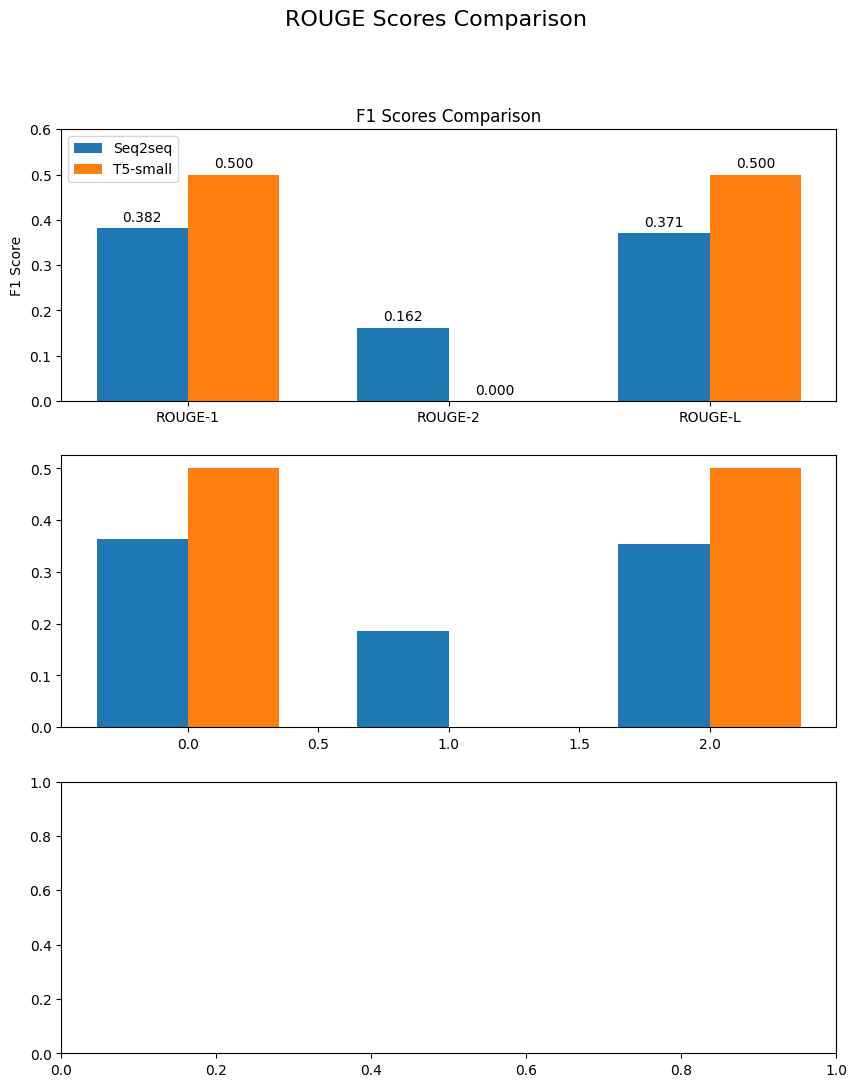

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your table
metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
models = ['Seq2seq + Coverage', 'T5-small']

# F1 Scores
seq2seq_f1 = [0.382, 0.162, 0.371]
t5_f1 = [0.500, 0.000, 0.500]

# Precision Scores
seq2seq_prec = [0.363, 0.185, 0.353]
t5_prec = [0.500, 0.000, 0.500]

# Recall Scores
seq2seq_rec = [0.393, 0.158, 0.370]
t5_rec = [0.500, 0.000, 0.500]

x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

# Create figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
fig.suptitle('ROUGE Scores Comparison', fontsize=16)

# F1 Score Plot
rects1 = ax1.bar(x - width/2, seq2seq_f1, width, label='Seq2seq', color='#1f77b4')
rects2 = ax1.bar(x + width/2, t5_f1, width, label='T5-small', color='#ff7f0e')
ax1.set_ylabel('F1 Score')
ax1.set_title('F1 Scores Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()
ax1.set_ylim(0, 0.6)
ax1.bar_label(rects1, padding=3, fmt='%.3f')
ax1.bar_label(rects2, padding=3, fmt='%.3f')

# Precision Plot
rects3 = ax2.bar(x - width/2, seq2seq_prec, width, label='Seq2seq', color='#1f77b4')
rects4 = ax2.bar(x + width/2, t5_prec, width, label='T5-small', color='#ff7f0e')
ax2.set_